In [22]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt

## Prediction of Closing Price of Stock LSTM
The goal is to predict the Closing Price behavior of a single company by predicting `n` coming days (`foward_days`), using as input the `m` past days (`look_back`).

### (Prevendo o preço de uma ação no mercado de ações)

O objetivo é prever o que acontecerá com o valor de fechamento de uma ação em `n` dias (`foward_days`), tendo como base os `m` dias anteriores (`look_back`).

In [23]:
look_back = 40
foward_days = 10

First, just open the CSV using Pandas, set the `Date` as index and keep only the Closing Price column.

Primeiro, vamos abrir o CSV com o Pandas, colocar as datas como index e manter apenas a coluna que queremos prever, que é o preço de fechamento.

In [24]:
#open the csv
df = pd.read_csv('data/company_D.csv')
#set date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#keep only the 'Close' column
df = df['Close']

df.head()

Date
2010-01-08    20.830000
2010-01-11    20.950001
2010-01-12    20.610001
2010-01-13    20.959999
2010-01-14    21.480000
Name: Close, dtype: float64

In [25]:
len(df)

2264

### Data visualization  ( Vizualizando os dados )

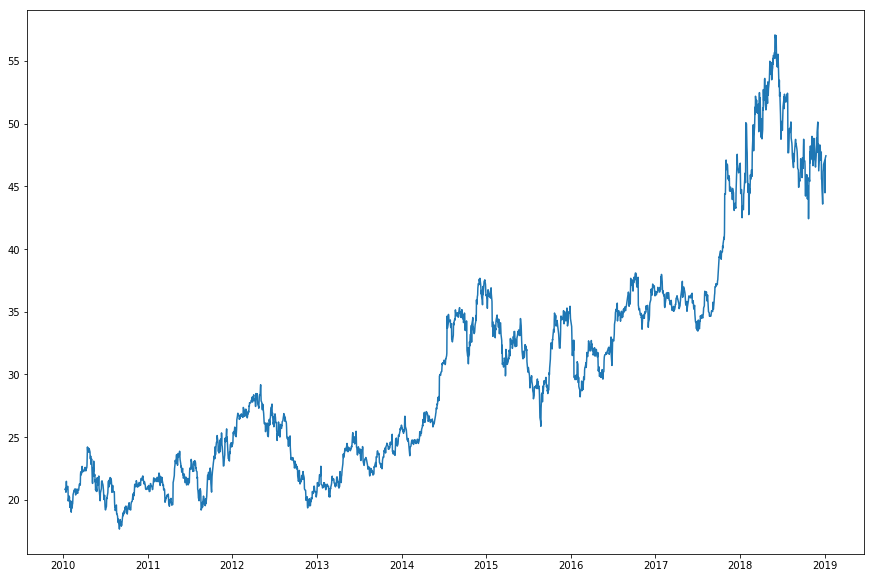

In [26]:
plt.figure(figsize = (15,10))
plt.plot(df)
plt.show()

### Data normalization  ( Normalizando os dados )

In [27]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[20.83    ],
       [20.950001],
       [20.610001],
       [20.959999],
       [21.48    ]])

In [28]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.08018269],
       [0.08322763],
       [0.07460038],
       [0.08348132],
       [0.09667597]])

### Split the data in Data to Train/Validate the LSTM and Data to Test the model

The Test set will be the last `k` (`num_periods`) periods we want test the model. In each period, the model will predict the next `n` coming days. The remaning data will be used for Train/Validation.

### ( Dividir os dados em Treino/Validação para o modelo LSTM e os dados de Teste)
Vamos separar para os últimos `k` períodos (`num_periods`) para testar o modelo. A cada período, o modelo irá prever os próximos `n` dias. O resto será utilizado para o treinamento (Treino e Validação).

In [29]:
#sepraro em Treino e Teste
num_periods = 20

division = len(array) - num_periods*foward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [30]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, foward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -foward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+foward_days)])
    return np.array(X),np.array(Y)

In [31]:
X_test,y_test = processData(array_test,look_back,foward_days,foward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,foward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1612, 40, 1)
(403, 40, 1)
(20, 40, 1)
(1612, 10)
(403, 10)
(20, 10)


## Training the LSTM (Treinando a LSTM)

In [44]:
NUM_NEURONS_FirstLayer = 128
NUM_NEURONS_SecondLayer = 64
EPOCHS = 220

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(foward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 1612 samples, validate on 403 samples
Epoch 1/220
 - 167s - loss: 0.0028 - val_loss: 0.0012
Epoch 2/220
 - 146s - loss: 0.0013 - val_loss: 0.0013
Epoch 3/220
 - 146s - loss: 0.0013 - val_loss: 8.7838e-04
Epoch 4/220
 - 146s - loss: 0.0011 - val_loss: 0.0015
Epoch 5/220
 - 147s - loss: 9.9737e-04 - val_loss: 7.9469e-04
Epoch 6/220
 - 148s - loss: 9.8243e-04 - val_loss: 7.3842e-04
Epoch 7/220
 - 147s - loss: 8.8925e-04 - val_loss: 7.4829e-04
Epoch 8/220
 - 147s - loss: 9.1433e-04 - val_loss: 8.2628e-04
Epoch 9/220
 - 147s - loss: 8.9678e-04 - val_loss: 9.3634e-04
Epoch 10/220
 - 146s - loss: 9.2239e-04 - val_loss: 8.8148e-04
Epoch 11/220
 - 147s - loss: 8.3553e-04 - val_loss: 8.4314e-04
Epoch 12/220
 - 146s - loss: 8.7240e-04 - val_loss: 7.3971e-04
Epoch 13/220
 - 147s - loss: 8.4713e-04 - val_loss: 7.0937e-04
Epoch 14/220
 - 146s - loss: 7.8890e-04 - val_loss: 7.6791e-04
Epoch 15/220
 - 146s - loss: 8.0819e-04 - val_loss: 7.1356e-04
Epoch 16/220
 - 147s - loss: 8.5010e-04 - val

Epoch 131/220
 - 147s - loss: 6.2097e-04 - val_loss: 6.8273e-04
Epoch 132/220
 - 147s - loss: 6.5059e-04 - val_loss: 6.5671e-04
Epoch 133/220
 - 147s - loss: 6.7113e-04 - val_loss: 6.7882e-04
Epoch 134/220
 - 147s - loss: 6.3823e-04 - val_loss: 7.0202e-04
Epoch 135/220
 - 147s - loss: 6.1679e-04 - val_loss: 7.7598e-04
Epoch 136/220
 - 147s - loss: 6.2751e-04 - val_loss: 6.8793e-04
Epoch 137/220
 - 147s - loss: 6.2096e-04 - val_loss: 7.1125e-04
Epoch 138/220
 - 147s - loss: 5.8144e-04 - val_loss: 6.7850e-04
Epoch 139/220
 - 147s - loss: 5.8588e-04 - val_loss: 7.2653e-04
Epoch 140/220
 - 147s - loss: 5.7682e-04 - val_loss: 7.4249e-04
Epoch 141/220
 - 148s - loss: 5.6920e-04 - val_loss: 6.5235e-04
Epoch 142/220
 - 147s - loss: 5.8945e-04 - val_loss: 6.5769e-04
Epoch 143/220
 - 147s - loss: 5.6637e-04 - val_loss: 8.4567e-04
Epoch 144/220
 - 148s - loss: 5.6521e-04 - val_loss: 6.2700e-04
Epoch 145/220
 - 148s - loss: 5.6034e-04 - val_loss: 5.9325e-04
Epoch 146/220
 - 147s - loss: 5.5471e-04

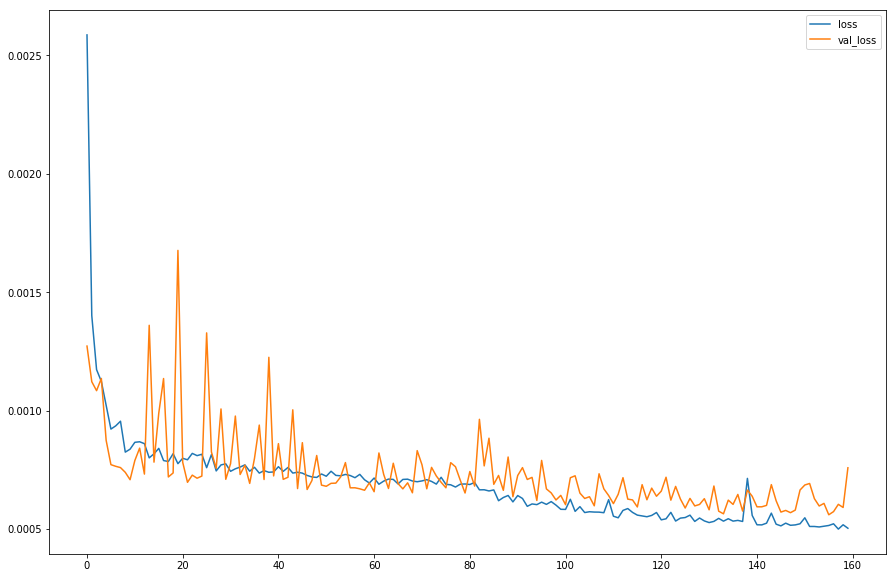

In [34]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [36]:
#Saving the model
file_name = 'Trained/single-company/LSTM_compD_LB{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, foward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `Trained/single-company/LSTM_compD_LB40_FD10_E160_F100_S50.h5` to disk


### Predicting the Test Set to see the results  ( Vamos prever os dados de Teste para o resultado )

In [37]:
Xt = model.predict(X_test)

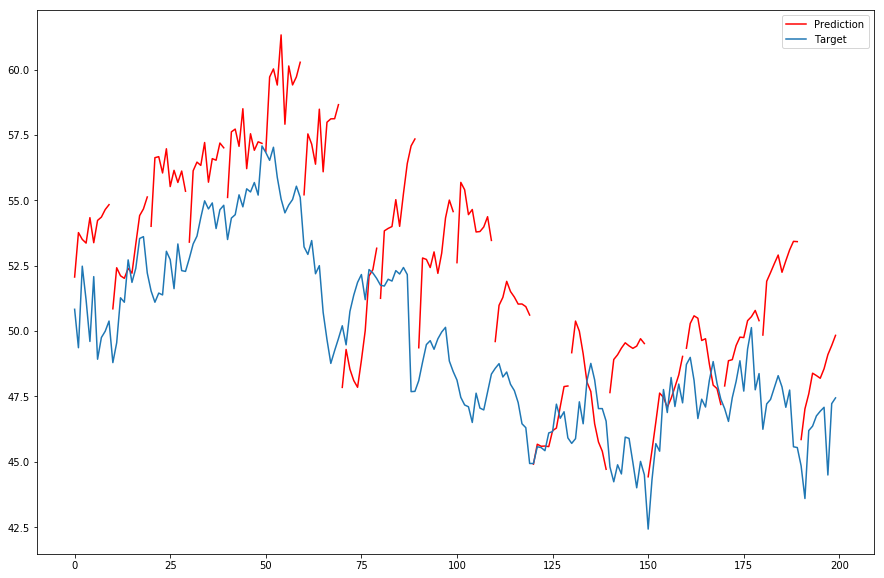

In [38]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*foward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

### Predicting all the data to see how the model reacts to Train and Test set
#### (Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste)

In [39]:
#sepraro em Treino e Teste

division = len(array) - num_periods*foward_days

leftover = division%foward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [40]:
Xtrain,ytrain = processData(array_train,look_back,foward_days,foward_days)
Xtest,ytest = processData(array_test,look_back,foward_days,foward_days)

In [41]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [42]:
#y = ytrain.ravel() + ytest.ravel()
y = np.concatenate((ytrain, ytest), axis=0)

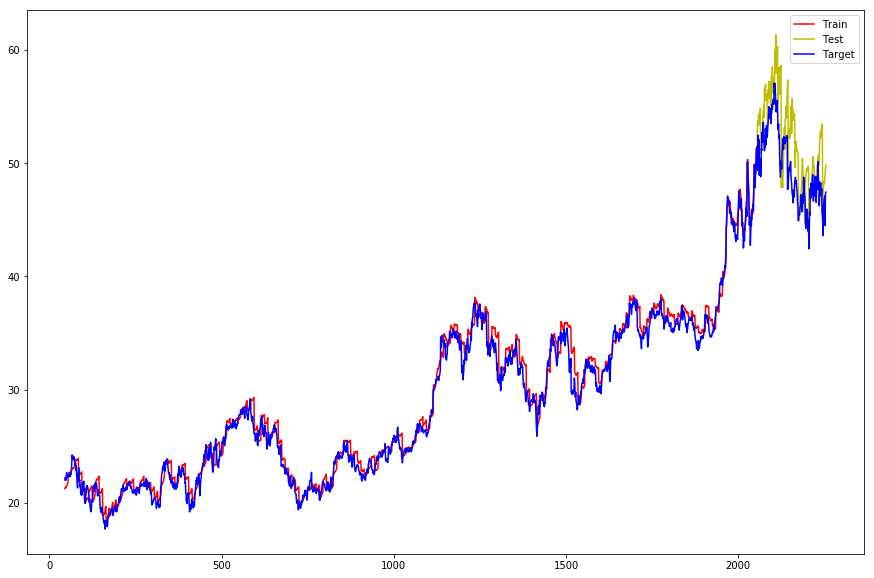

In [43]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data uses
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()